# Analysis of RNA-seq data

This `.ipynb` file should be placed in a directory titled `Code/`. 

In addition, one step *above* the `Code/` directory should be directories titled `Data/` and `Results/` such that file writing implemented here runs smoothly. 

So it doesn't matter where you put this directory, as long as the structure looks something like:

    my_cool_project/Code/
        RNA_seq_analysis.ipynb
        sequencing_analysis_library.py

    my_cool_project/Data/

    my_cool_project/Results/
    
In addition, in either your global path (if you don't know what this is fret not) OR your `my_cool_project/Code/` directory you will need to have `sequencing_analysis_library.py`

# Common imports / necessary helpful functions

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Common imports
from Bio import SeqIO
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

#My helper library for this analysis
import sequencing_analysis_library as SAL

# Reading the genome

In [3]:
genome_file = '/Users/adamhockenberry/Projects/Neisseria/Data/Genomes/fa1090.gb'
genome = list(SeqIO.parse(genome_file, 'genbank'))[0]
organism = 'Neisseria'

# Converting .SAM files to .wig files for easier use later
This will take some time, and doesn't need to be run every time through this notebook. 

Results are stored in ../Data/\*organism\*/ where \*organism\* is a specified variable below. Make sure this folder exists before running the code.

For each sequencing experiment, the output should be 5 files:
1. .wig for fwd reads
2. .wig for rev reads
3. .wig for fwd reads where reads at each nt are normalized by dividing by the total number of mapped reads * 10^9
4. .wig for rev reads where reads at each nt are normalized by dividing by the total number of mapped reads * 10^9
5. .summary file that contains pertinent information on the number of mapped reads

In [4]:
# generic_sam_file = '/Users/adamhockenberry/workspace/bowtie-1.1.0/SequencingData/Neisseria/SQ-X_filtered_no_rrnas.aligned.SAM'
# organism = 'Neisseria'
# # sample_files = ['SQ-1', 'SQ-2', 'SQ-3', 'SQ-4', 'SQ-5', 'SQ-6']
# # # sample_files = ['SQ-7', 'SQ-8', 'SQ-9', 'SQ-10', 'SQ-11', 'SQ-12']
# sample_files = ['SQ-13', 'SQ-14', 'SQ-15', 'SQ-16', 'SQ-17', 'SQ-18']
# for sample_file in sample_files:
#     SAL.sam_to_wiggle(generic_sam_file.replace('SQ-X', sample_file),\
#                       organism, length_restriction = (15, 45), assignment='all')

# Read in .wig files to calculate RPKM for each *annotated* feature in each dataset
Now that we have .wig files set up, we can load them in and calculate the rpkm for your genes / features of interest.

This portion of the analysis relies *heavily* / *exclusively* on the existing genome annotations. If you're skeptical of these existing annotations we'll get to novel transcript identification later.

In [5]:
sample_files = ['SQ-13', 'SQ-14', 'SQ-15', 'SQ-16', 'SQ-17', 'SQ-18']

organism = 'Neisseria'
file_ending = '_15_45_all'

rpkm_dict_meta, feature_dict, sequencing_dict_meta_f, sequencing_dict_meta_r =\
        SAL.wiggle_to_sequencing(genome, sample_files, organism, file_ending, feature_type='gene')

SQ-13: Total reads mapped:281998.0349482321 Percentage mapped to feature:38.00397856752872
SQ-14: Total reads mapped:724592.2887661391 Percentage mapped to feature:39.129088791562
SQ-15: Total reads mapped:248384.19101864976 Percentage mapped to feature:38.58779341386353
SQ-16: Total reads mapped:836388.3872506594 Percentage mapped to feature:38.34984064464055
SQ-17: Total reads mapped:765652.0417670998 Percentage mapped to feature:37.62927421392173
SQ-18: Total reads mapped:983341.0624742247 Percentage mapped to feature:37.38543751658031


# Differential expression
Now that we have an rpkm value for each gene in each condition we can test for differential expression using either a t-test or my preference of a t-test on the log-transformed rpkm values in the two different conditions. 

In [6]:
gene_names = []
col_names = ['RPKM(SQ-13)','RPKM(SQ-15)','RPKM(SQ-17)',\
             'RPKM(SQ-14)','RPKM(SQ-16)','RPKM(SQ-18)',\
             'Avg (SQ-13, SQ-15, SQ-17)', 'St.Dev. (SQ-13, SQ-15, SQ-17)',\
             'Avg (SQ-14, SQ-16, SQ-18)', 'St.Dev. (SQ-14, SQ-16, SQ-18)',\
             'T-test(p-value)', 'T-test(p-value) on log transformed RPKM']

data_table = []
for gene in rpkm_dict_meta['SQ-13'].keys():
    gene_names.append(gene)
    a = rpkm_dict_meta['SQ-13'][gene]
    c = rpkm_dict_meta['SQ-15'][gene]
    e = rpkm_dict_meta['SQ-17'][gene]
    
    b = rpkm_dict_meta['SQ-14'][gene]
    d = rpkm_dict_meta['SQ-16'][gene]
    f = rpkm_dict_meta['SQ-18'][gene]
    
    condition_1 = [a, c, e]
    condition_2 = [b, d, f]
    t_val, p_val= stats.ttest_ind(condition_1, condition_2)
    
    condition_1_log = [np.log2(a), np.log2(c), np.log2(e)]
    condition_2_log = [np.log2(b), np.log2(d), np.log2(f)]
    t_val_log, p_val_log = stats.ttest_ind(condition_1_log, condition_2_log)
    
    data_table.append([a, c, e, b, d, f,\
                       np.mean(condition_1), np.std(condition_1),\
                       np.mean(condition_2), np.std(condition_2),\
                       p_val, p_val_log])

df = pd.DataFrame(data_table, index=gene_names, columns=col_names)

# Save the expression data for each feature to an excel-readable file

In [ ]:
sort_df = df.sort('T-test(p-value)')
sort_df.to_excel('../Results/Neisseria_gonorrhea_Ribo_seq.xlsx', sheet_name='Sheet1')

# Read that file back in

In [7]:
df = pd.read_excel('../Results/Neisseria_gonorrhea_Ribo_seq.xlsx', sheet_name='Sheet1')

# Test correlations between datasets

In [8]:
print('####################################')
print("Normal conditions")
print(stats.spearmanr(df['RPKM(SQ-13)'], df['RPKM(SQ-15)']))
print(stats.spearmanr(df['RPKM(SQ-13)'], df['RPKM(SQ-17)']))
print(stats.spearmanr(df['RPKM(SQ-15)'], df['RPKM(SQ-17)']))
print('####################################')
print("Oxidative stress")
print(stats.spearmanr(df['RPKM(SQ-14)'], df['RPKM(SQ-16)']))
print(stats.spearmanr(df['RPKM(SQ-14)'], df['RPKM(SQ-18)']))
print(stats.spearmanr(df['RPKM(SQ-16)'], df['RPKM(SQ-18)']))
print('####################################')
print("Comparion between conditions")
print(stats.spearmanr(df['RPKM(SQ-13)'], df['RPKM(SQ-14)']))
print(stats.spearmanr(df['RPKM(SQ-13)'], df['RPKM(SQ-16)']))
print(stats.spearmanr(df['RPKM(SQ-13)'], df['RPKM(SQ-18)']))
print(stats.spearmanr(df['RPKM(SQ-15)'], df['RPKM(SQ-14)']))
print(stats.spearmanr(df['RPKM(SQ-15)'], df['RPKM(SQ-16)']))
print(stats.spearmanr(df['RPKM(SQ-15)'], df['RPKM(SQ-18)']))
print(stats.spearmanr(df['RPKM(SQ-17)'], df['RPKM(SQ-14)']))
print(stats.spearmanr(df['RPKM(SQ-17)'], df['RPKM(SQ-16)']))
print(stats.spearmanr(df['RPKM(SQ-17)'], df['RPKM(SQ-18)']))

####################################
Normal conditions
(0.25034339052876131, 1.3295234419728739e-29)
(0.33693992508336185, 1.2484334694794569e-53)
(0.35572334619065188, 5.4750327050751031e-60)
####################################
Oxidative stress
(0.39011218988617685, 8.5049731549472195e-73)
(0.45639482726986369, 3.3593930292735676e-102)
(0.65254468349818051, 5.5511568885705172e-240)
####################################
Comparion between conditions
(0.25781871410244034, 2.3512265150475014e-31)
(0.27406933640824532, 2.2898583583625161e-35)
(0.35546455415469708, 6.7447673362287708e-60)
(0.25207414765747299, 5.2857692652800044e-30)
(0.2850272485910329, 3.1302973973671352e-38)
(0.35835651314247796, 6.4853586635321962e-61)
(0.44908988722580001, 1.2526085689951052e-98)
(0.64013898529691737, 3.5848778761739934e-228)
(0.8272847250541413, 0.0)


# View correlation plots between any conditions

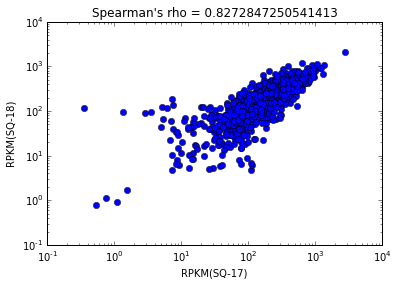

In [9]:
to_compare_a = 'RPKM(SQ-17)'
to_compare_b = 'RPKM(SQ-18)'
SAL.plot_correlations_single(to_compare_a, to_compare_b, df, save_file_name='SQ-17_vs_SQ-18')

# View correlation, averaging across replicates for each condition

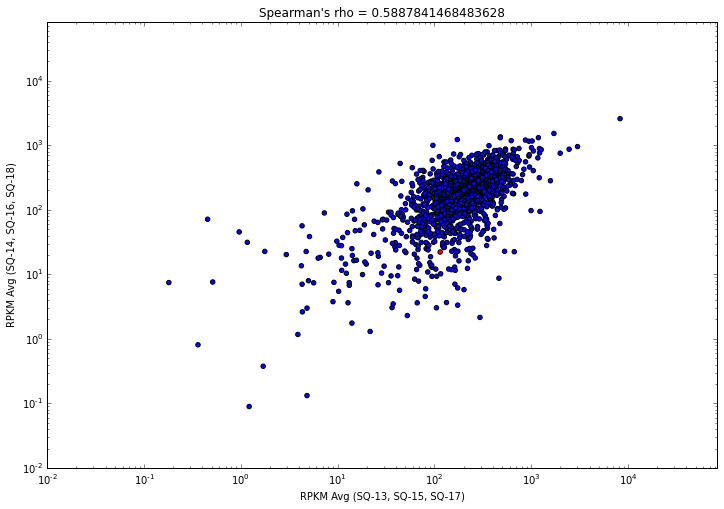

In [10]:
to_compare_a = 'Avg (SQ-13, SQ-15, SQ-17)'
to_compare_b = 'Avg (SQ-14, SQ-16, SQ-18)'
SAL.plot_correlations_combined(to_compare_a, to_compare_b, df, p_val_threshold=0.01, save_file_name='Ribo_seq_combined.pdf')

# Visualize data for individual genes

In [11]:
control_labels = ['SQ-13', 'SQ-15', 'SQ-17']
treatment_labels = ['SQ-14', 'SQ-16', 'SQ-18']
sequencing_dict_meta_f_normed, sequencing_dict_meta_r_normed =\
        SAL.read_normed_wiggle(genome, sample_files, organism, file_ending, feature_type='CDS')

RPKM(SQ-13)                                283.033389
RPKM(SQ-15)                                 61.519829
RPKM(SQ-17)                                224.875448
RPKM(SQ-14)                                 91.990846
RPKM(SQ-16)                                101.694501
RPKM(SQ-18)                                161.490428
Avg (SQ-13, SQ-15, SQ-17)                  189.809555
St.Dev. (SQ-13, SQ-15, SQ-17)               93.770205
Avg (SQ-14, SQ-16, SQ-18)                  118.391925
St.Dev. (SQ-14, SQ-16, SQ-18)               30.731645
T-test(p-value)                              0.363917
T-test(p-value) on log transformed RPKM      0.564213
Name: NGO1496, dtype: float64


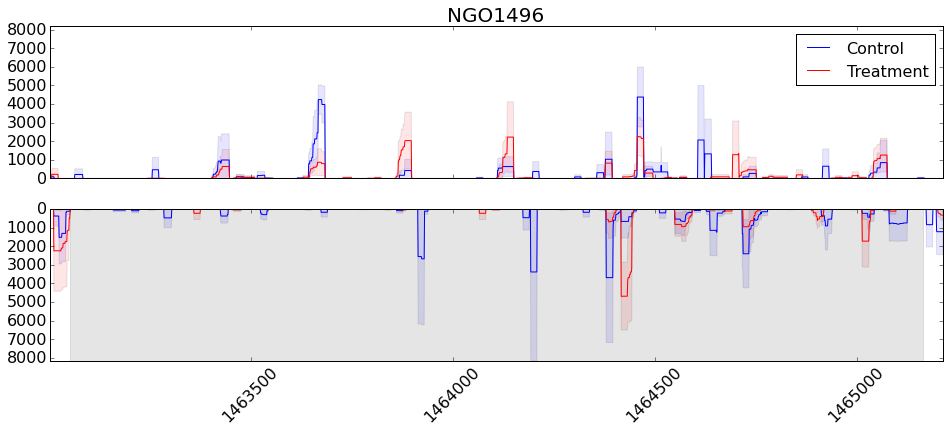

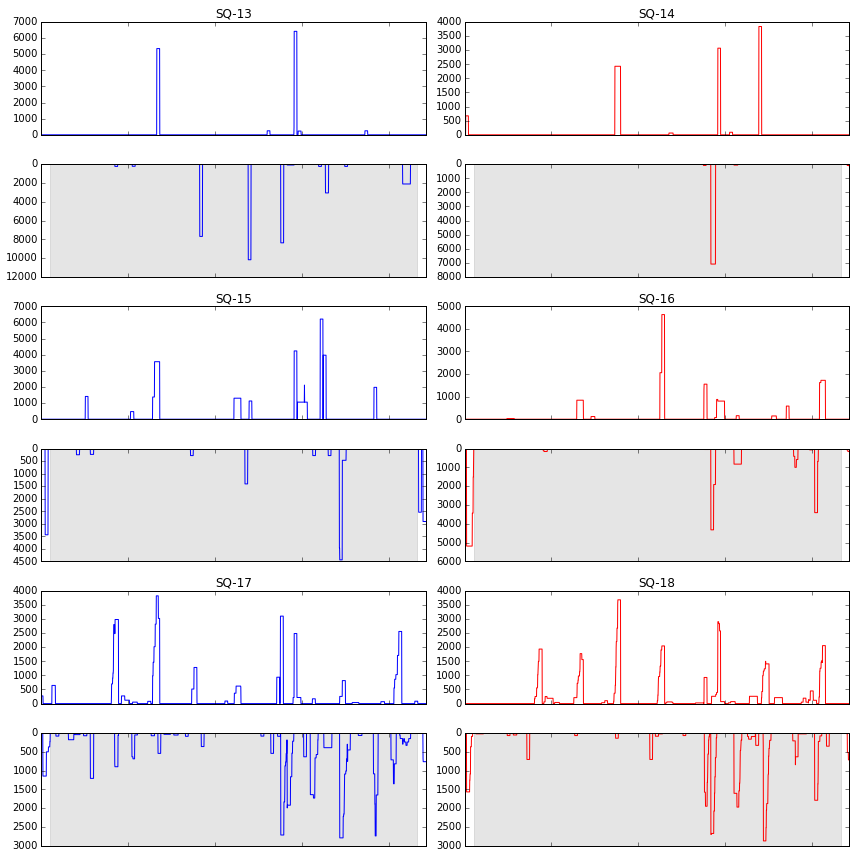

In [12]:
# feature_name = 'NGO1496'
# feature_beg, feature_end = (int(feature_dict[feature_name].location.start), int(feature_dict[feature_name].location.end))
# feature_strand = feature_dict[feature_name].strand
# SAL.plot_individual_segment(feature_beg, feature_end, feature_strand, control_labels, treatment_labels,\
#                          sequencing_dict_meta_f_normed, sequencing_dict_meta_r_normed,\
#                          bases_to_add=100, feature_name=feature_name, save_file=False)


feature_name = 'NGO1496'
print(df.loc[feature_name])
bases_to_add = 50
window_beg, window_end = (int(feature_dict[feature_name].location.start), int(feature_dict[feature_name].location.end))
window_beg = window_beg - bases_to_add
window_end = window_end + bases_to_add
defined_ylimits = False
save_file = False
individual_plots = True
SAL.plot_individual_segment(window_beg, window_end, [feature_dict[feature_name]], control_labels, treatment_labels,\
                        sequencing_dict_meta_f_normed, sequencing_dict_meta_r_normed,\
                        defined_ylimits=defined_ylimits, feature_name=feature_name, save_file=save_file, individual_plots=individual_plots)



# Iterate through single column excel file of gene names to visualize and save plots for relavant genes in `../Results/todays_date/`

In [13]:
data_to_plot = pd.read_excel('/Users/adamhockenberry/Downloads/Ribo-SeqCandidates.xlsx', header=None, index_col=0)
for feature_name in data_to_plot.index:
    bases_to_add = 50
    window_beg, window_end = (int(feature_dict[feature_name].location.start), int(feature_dict[feature_name].location.end))
    window_beg = window_beg - bases_to_add
    window_end = window_end + bases_to_add
    defined_ylimits = False
    save_file = True
    individual_plots = True
    SAL.plot_individual_segment(window_beg, window_end, [feature_dict[feature_name]], control_labels, treatment_labels,\
                            sequencing_dict_meta_f_normed, sequencing_dict_meta_r_normed,\
                            defined_ylimits=defined_ylimits, feature_name=feature_name, save_file=save_file, individual_plots=individual_plots)




In [ ]:
# first = 0
# second = 0
# third = 0
# for gene in sequencing_dict_meta['SQ-1']:
#     for i in range(0, len(sequencing_dict_meta['SQ-1'][gene]),3):
#         first += sequencing_dict_meta['SQ-1'][gene][i]
#     for i in range(1, len(sequencing_dict_meta['SQ-1'][gene]),3):
#         second += sequencing_dict_meta['SQ-1'][gene][i]
#     for i in range(2, len(sequencing_dict_meta['SQ-1'][gene]),3):
#         third += sequencing_dict_meta['SQ-1'][gene][i]
# print(first, second, third)

# What about un-annotated genes?
The above analysis relied entirely on the published, annotated genome sequences. An interesting part of RNA-seq analysis is that perhaps we can find novel unannotated transcripts or sRNAs.

First, we'll identify differentially expressed "regions" via a brute force approach that doesn't rely on annotations. 

In [ ]:
control_labels = ['SQ-1', 'SQ-3', 'SQ-5']
treatment_labels = ['SQ-2', 'SQ-4', 'SQ-6']


window_size = 100
step_size = 10
beginning, end = (100000, 150000)


# ctrl_fpkm_avg_plus = []
# ctrl_fpkm_avg_minus = []
# treatment_fpkm_avg_plus = []
# treatment_fpkm_avg_minus = []

# p_vals_plus = []
# p_vals_minus = []

# xcoords = []

# for i in range(beginning,end-window_size, step_size):
#     treatment_vals_plus = []
#     control_vals_plus = []
#     treatment_vals_minus = []
#     control_vals_minus = []
#     for label in total_dict.keys():
#         temp_plus = []
#         temp_minus = []
#         for j in range(i, i+window_size):
#             try:
#                 temp_plus.append(sequencing_dict_meta_f[label][j])
#             except KeyError:
#                 temp_plus.append(0)
#             try:
#                 temp_minus.append(sequencing_dict_meta_r[label][j])
#             except KeyError:
#                 temp_minus.append(0)
                        
#         fpkm_plus = (np.sum(temp_plus) * 1000000000) / (len(temp_plus) * total_dict[label])
#         fpkm_minus = (np.sum(temp_minus) * 1000000000) / (len(temp_plus) * total_dict[label])

#         if label in control_labels:
#             control_vals_plus.append(fpkm_plus)
#             control_vals_minus.append(fpkm_minus)

#         elif label in treatment_labels:
#             treatment_vals_plus.append(fpkm_plus)
#             treatment_vals_minus.append(fpkm_minus)
    
#     ctrl_fpkm_avg_plus.append(np.mean(control_vals_plus))
#     ctrl_fpkm_avg_minus.append(np.mean(control_vals_minus))
#     treatment_fpkm_avg_plus.append(np.mean(treatment_vals_plus))
#     treatment_fpkm_avg_minus.append(np.mean(treatment_vals_minus))


#     t, p = stats.ttest_ind(control_vals_plus, treatment_vals_plus, equal_var=False)
#     p_vals_plus.append(p)
    
#     t, p = stats.ttest_ind(control_vals_minus, treatment_vals_minus, equal_var=False)
#     p_vals_minus.append(p)
    
#     xcoords.append(i)

In [ ]:
y_ax = [5, 2, 5, 6]
x_ax = [1, 2, 3, 4]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.semilogy(x_ax, y_ax)
ax1.invert_yaxis()